In [1]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_synsigns, load_GTSRB
from models import DomainAdaptationNetwork, get_simple_classifier

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_tsne

In [2]:
torch.manual_seed(1)
import numpy as np
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(in_channels=self.conv_feat_size[0], out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=nb_channels, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_share, z_spe):
        z = torch.cat([z_share, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.InstanceNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.InstanceNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.InstanceNorm2d(128),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Sequential(
            nn.Linear(in_features=self.dense_feature_size, out_features=1024),
            nn.ReLU(True), )

        self.share_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

        self.source_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

        self.target_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

    def forward(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_share = self.share_feat(feat)
        z_source = self.source_feat(feat)
        z_target = self.target_feat(feat)
        return z_share, z_source, z_target

    def forward_share(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_share = self.share_feat(feat)
        return z_share

    def forward_source(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_source = self.source_feat(feat)
        return z_source

    def forward_target(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_target = self.target_feat(feat)
        return z_target


In [4]:
def get_simple_classifier(latent_space_dim=1024):
    return nn.Sequential(nn.Dropout2d(),
                         nn.Linear(in_features=latent_space_dim, out_features=43),
                         nn.LogSoftmax())

In [5]:
target_loader = load_GTSRB(img_size=64, batch_size=128, shuffle=True, num_workers=2)
source_loader = load_synsigns(img_size=64, batch_size=128, shuffle=True, num_workers=2)

learning_rate = 5e-4
#epochs=10
epochs=30

encoder = Encoder(latent_space_dim=75, img_size=(3,64,64), nb_channels=3)
conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=3)
decoder_target = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=3)
classifier = get_simple_classifier(latent_space_dim=75)
model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()

betas = np.ones(30) * 10
betas[:10] = np.linspace(0, 10, 10)
#betas = np.linspace(0, 5, 30)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.001)

train_domain_adaptation(model, optimizer, source_loader, target_loader, betas=betas,
                                            epochs=epochs, alpha=1, gamma=0.5, delta=0.5, show_images=False)

  0%|          | 0/30 [00:00<?, ?it/s]/home/david.bertoin/.conda/envs/domain_adaptation/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
epoch:0 current target accuracy:44.29%:   0%|          | 0/30 [01:41<?, ?it/s]

epoch [1/30], loss:0.9551
accuracy source: 85.95%
accuracy target: 44.39%


epoch:1 current target accuracy:81.65%:   3%|▎         | 1/30 [03:26<50:40, 104.86s/it]

epoch [2/30], loss:0.7746
accuracy source: 98.58%
accuracy target: 81.83%


epoch:2 current target accuracy:91.24%:   7%|▋         | 2/30 [05:11<48:56, 104.89s/it]

epoch [3/30], loss:0.6332
accuracy source: 99.46%
accuracy target: 91.44%


epoch:3 current target accuracy:94.1%:  10%|█         | 3/30 [06:55<47:12, 104.90s/it] 

epoch [4/30], loss:0.5744
accuracy source: 99.54%
accuracy target: 94.31%


epoch:4 current target accuracy:94.94%:  13%|█▎        | 4/30 [08:40<45:27, 104.91s/it]

epoch [5/30], loss:0.5634
accuracy source: 99.64%
accuracy target: 95.15%


epoch:5 current target accuracy:95.22%:  17%|█▋        | 5/30 [10:26<43:44, 104.96s/it]

epoch [6/30], loss:0.5577
accuracy source: 99.63%
accuracy target: 95.43%


epoch:6 current target accuracy:96.17%:  20%|██        | 6/30 [12:10<41:59, 104.97s/it]

epoch [7/30], loss:0.5492
accuracy source: 99.63%
accuracy target: 96.38%


epoch:7 current target accuracy:95.35%:  23%|██▎       | 7/30 [13:55<40:14, 104.97s/it]

epoch [8/30], loss:0.5399
accuracy source: 99.61%
accuracy target: 95.56%


epoch:8 current target accuracy:93.18%:  27%|██▋       | 8/30 [15:41<38:29, 104.99s/it]

epoch [9/30], loss:0.5395
accuracy source: 99.62%
accuracy target: 93.39%


epoch:9 current target accuracy:92.99%:  30%|███       | 9/30 [17:25<36:44, 104.99s/it]

epoch [10/30], loss:0.5373
accuracy source: 99.64%
accuracy target: 93.2%


epoch:10 current target accuracy:94.94%:  33%|███▎      | 10/30 [19:10<34:59, 104.97s/it]

epoch [11/30], loss:0.5121
accuracy source: 99.7%
accuracy target: 95.15%


epoch:11 current target accuracy:94.94%:  37%|███▋      | 11/30 [20:55<33:14, 104.97s/it]

epoch [12/30], loss:0.5102
accuracy source: 99.73%
accuracy target: 95.15%


epoch:12 current target accuracy:96.2%:  40%|████      | 12/30 [22:40<31:29, 104.99s/it] 

epoch [13/30], loss:0.5008
accuracy source: 99.75%
accuracy target: 96.42%


epoch:13 current target accuracy:96.72%:  43%|████▎     | 13/30 [24:25<29:45, 105.00s/it]

epoch [14/30], loss:0.5052
accuracy source: 99.67%
accuracy target: 96.93%


epoch:14 current target accuracy:96.81%:  47%|████▋     | 14/30 [26:11<28:00, 105.02s/it]

epoch [15/30], loss:0.4895
accuracy source: 99.76%
accuracy target: 97.03%


epoch:15 current target accuracy:96.61%:  50%|█████     | 15/30 [27:56<26:15, 105.05s/it]

epoch [16/30], loss:0.4896
accuracy source: 99.71%
accuracy target: 96.83%


epoch:16 current target accuracy:97.1%:  53%|█████▎    | 16/30 [29:41<24:30, 105.05s/it] 

epoch [17/30], loss:0.4875
accuracy source: 99.76%
accuracy target: 97.31%


epoch:17 current target accuracy:97.11%:  57%|█████▋    | 17/30 [31:26<22:45, 105.02s/it]

epoch [18/30], loss:0.4755
accuracy source: 99.79%
accuracy target: 97.33%


epoch:18 current target accuracy:97.03%:  60%|██████    | 18/30 [33:11<20:59, 104.99s/it]

epoch [19/30], loss:0.4744
accuracy source: 99.78%
accuracy target: 97.25%


epoch:19 current target accuracy:97.19%:  63%|██████▎   | 19/30 [34:56<19:14, 105.00s/it]

epoch [20/30], loss:0.4676
accuracy source: 99.76%
accuracy target: 97.4%


epoch:20 current target accuracy:97.23%:  67%|██████▋   | 20/30 [36:41<17:30, 105.01s/it]

epoch [21/30], loss:0.4746
accuracy source: 99.77%
accuracy target: 97.45%


epoch:21 current target accuracy:96.9%:  70%|███████   | 21/30 [38:25<15:44, 104.98s/it] 

epoch [22/30], loss:0.4832
accuracy source: 99.71%
accuracy target: 97.11%


epoch:22 current target accuracy:97.01%:  73%|███████▎  | 22/30 [40:10<13:59, 104.96s/it]

epoch [23/30], loss:0.4838
accuracy source: 99.77%
accuracy target: 97.23%


epoch:23 current target accuracy:94.52%:  77%|███████▋  | 23/30 [41:55<12:14, 104.95s/it]

epoch [24/30], loss:0.4816
accuracy source: 99.76%
accuracy target: 94.73%


epoch:24 current target accuracy:95.07%:  80%|████████  | 24/30 [43:40<10:29, 104.94s/it]

epoch [25/30], loss:0.4885
accuracy source: 99.69%
accuracy target: 95.28%


epoch:25 current target accuracy:96.59%:  83%|████████▎ | 25/30 [45:25<08:44, 104.93s/it]

epoch [26/30], loss:0.4778
accuracy source: 99.76%
accuracy target: 96.81%


epoch:26 current target accuracy:97.17%:  87%|████████▋ | 26/30 [47:10<06:59, 104.93s/it]

epoch [27/30], loss:0.4652
accuracy source: 99.78%
accuracy target: 97.38%


epoch:27 current target accuracy:97.25%:  90%|█████████ | 27/30 [48:55<05:14, 104.94s/it]

epoch [28/30], loss:0.4645
accuracy source: 99.79%
accuracy target: 97.47%


epoch:28 current target accuracy:96.96%:  93%|█████████▎| 28/30 [50:40<03:29, 104.92s/it]

epoch [29/30], loss:0.4876
accuracy source: 99.72%
accuracy target: 97.18%


epoch:29 current target accuracy:96.83%:  97%|█████████▋| 29/30 [52:25<01:44, 104.91s/it]

epoch [30/30], loss:0.4753
accuracy source: 99.78%
accuracy target: 97.05%


epoch:29 current target accuracy:96.83%: 100%|██████████| 30/30 [52:29<00:00, 104.97s/it]


In [7]:
model.eval()
test_network(model, target_loader)

/home/david.bertoin/.conda/envs/domain_adaptation/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9720217297049147

In [10]:
betas = np.ones(30) * 10
#betas = np.linspace(0, 5, 30)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=0.001)

train_domain_adaptation(model, optimizer, source_loader, target_loader, betas=betas,
                                            epochs=epochs, alpha=5, gamma=0.5, delta=0.5, show_images=False)

epoch:0 current target accuracy:97.01%:   0%|          | 0/30 [01:39<?, ?it/s]

epoch [1/30], loss:2.0674
accuracy source: 99.8%
accuracy target: 97.22%


epoch:1 current target accuracy:97.05%:   3%|▎         | 1/30 [03:24<49:58, 103.41s/it]

epoch [2/30], loss:2.0427
accuracy source: 99.89%
accuracy target: 97.26%


epoch:2 current target accuracy:97.1%:   7%|▋         | 2/30 [05:09<48:26, 103.80s/it] 

epoch [3/30], loss:2.0327
accuracy source: 99.89%
accuracy target: 97.32%


epoch:3 current target accuracy:97.12%:  10%|█         | 3/30 [06:54<46:51, 104.12s/it]

epoch [4/30], loss:2.0252
accuracy source: 99.89%
accuracy target: 97.33%


epoch:4 current target accuracy:97.11%:  13%|█▎        | 4/30 [08:39<45:14, 104.39s/it]

epoch [5/30], loss:2.0166
accuracy source: 99.87%
accuracy target: 97.33%


epoch:5 current target accuracy:97.13%:  17%|█▋        | 5/30 [10:24<43:35, 104.62s/it]

epoch [6/30], loss:2.0069
accuracy source: 99.89%
accuracy target: 97.35%


epoch:6 current target accuracy:97.14%:  20%|██        | 6/30 [12:09<41:55, 104.82s/it]

epoch [7/30], loss:2.0019
accuracy source: 99.84%
accuracy target: 97.35%


epoch:7 current target accuracy:97.11%:  23%|██▎       | 7/30 [13:54<40:12, 104.89s/it]

epoch [8/30], loss:1.9950
accuracy source: 99.92%
accuracy target: 97.33%


epoch:8 current target accuracy:97.13%:  27%|██▋       | 8/30 [15:39<38:28, 104.93s/it]

epoch [9/30], loss:1.9868
accuracy source: 99.9%
accuracy target: 97.34%


epoch:9 current target accuracy:97.13%:  30%|███       | 9/30 [17:24<36:44, 104.96s/it]

epoch [10/30], loss:1.9818
accuracy source: 99.89%
accuracy target: 97.34%


epoch:10 current target accuracy:97.13%:  33%|███▎      | 10/30 [19:09<34:59, 104.96s/it]

epoch [11/30], loss:1.9777
accuracy source: 99.9%
accuracy target: 97.34%


epoch:11 current target accuracy:97.1%:  37%|███▋      | 11/30 [20:54<33:14, 104.95s/it] 

epoch [12/30], loss:1.9753
accuracy source: 99.92%
accuracy target: 97.32%


epoch:12 current target accuracy:97.09%:  40%|████      | 12/30 [22:39<31:29, 104.98s/it]

epoch [13/30], loss:1.9705
accuracy source: 99.92%
accuracy target: 97.31%


epoch:13 current target accuracy:97.11%:  43%|████▎     | 13/30 [24:24<29:44, 104.98s/it]

epoch [14/30], loss:1.9635
accuracy source: 99.93%
accuracy target: 97.33%


epoch:14 current target accuracy:97.11%:  47%|████▋     | 14/30 [26:09<28:00, 105.00s/it]

epoch [15/30], loss:1.9642
accuracy source: 99.91%
accuracy target: 97.33%


epoch:15 current target accuracy:97.11%:  50%|█████     | 15/30 [27:54<26:15, 105.01s/it]

epoch [16/30], loss:1.9607
accuracy source: 99.91%
accuracy target: 97.32%


epoch:16 current target accuracy:97.12%:  53%|█████▎    | 16/30 [29:39<24:29, 104.99s/it]

epoch [17/30], loss:1.9585
accuracy source: 99.9%
accuracy target: 97.33%


epoch:17 current target accuracy:97.11%:  57%|█████▋    | 17/30 [31:24<22:45, 105.02s/it]

epoch [18/30], loss:1.9514
accuracy source: 99.93%
accuracy target: 97.33%


epoch:18 current target accuracy:97.12%:  60%|██████    | 18/30 [33:09<20:59, 104.99s/it]

epoch [19/30], loss:1.9515
accuracy source: 99.89%
accuracy target: 97.34%


epoch:19 current target accuracy:97.13%:  63%|██████▎   | 19/30 [34:54<19:15, 105.04s/it]

epoch [20/30], loss:1.9469
accuracy source: 99.9%
accuracy target: 97.34%


epoch:20 current target accuracy:97.11%:  67%|██████▋   | 20/30 [36:40<17:30, 105.06s/it]

epoch [21/30], loss:1.9457
accuracy source: 99.91%
accuracy target: 97.33%


epoch:21 current target accuracy:97.12%:  70%|███████   | 21/30 [38:25<15:46, 105.11s/it]

epoch [22/30], loss:1.9453
accuracy source: 99.9%
accuracy target: 97.33%


epoch:22 current target accuracy:97.11%:  73%|███████▎  | 22/30 [40:10<14:01, 105.15s/it]

epoch [23/30], loss:1.9427
accuracy source: 99.9%
accuracy target: 97.33%


epoch:23 current target accuracy:97.13%:  77%|███████▋  | 23/30 [41:55<12:16, 105.16s/it]

epoch [24/30], loss:1.9391
accuracy source: 99.91%
accuracy target: 97.34%


epoch:24 current target accuracy:97.11%:  80%|████████  | 24/30 [43:40<10:31, 105.17s/it]

epoch [25/30], loss:1.9414
accuracy source: 99.93%
accuracy target: 97.32%


epoch:25 current target accuracy:97.12%:  83%|████████▎ | 25/30 [45:26<08:45, 105.14s/it]

epoch [26/30], loss:1.9349
accuracy source: 99.91%
accuracy target: 97.34%


epoch:26 current target accuracy:97.11%:  87%|████████▋ | 26/30 [47:11<07:00, 105.12s/it]

epoch [27/30], loss:1.9401
accuracy source: 99.9%
accuracy target: 97.32%


epoch:27 current target accuracy:97.11%:  90%|█████████ | 27/30 [48:56<05:15, 105.08s/it]

epoch [28/30], loss:1.9360
accuracy source: 99.91%
accuracy target: 97.32%


epoch:28 current target accuracy:97.12%:  93%|█████████▎| 28/30 [50:41<03:30, 105.09s/it]

epoch [29/30], loss:1.9335
accuracy source: 99.92%
accuracy target: 97.33%


epoch:29 current target accuracy:97.11%:  97%|█████████▋| 29/30 [52:26<01:45, 105.14s/it]

epoch [30/30], loss:1.9306
accuracy source: 99.92%
accuracy target: 97.33%


epoch:29 current target accuracy:97.11%: 100%|██████████| 30/30 [52:30<00:00, 105.01s/it]


In [11]:
model.eval()
test_network(model, target_loader)

0.9737815297508225

In [12]:
import matplotlib.pyplot as plt
def plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader):
    X, _ = next(iter(target_train_loader))
    y, _, (z_share, z_spe),  _, _ = model.forward_t(X.cuda())
    X2, _ = next(iter(source_train_loader))
    _, _, (z_share, _),  _, _ = model.forward_t(X2.cuda())
    #blank
    plt.subplot(1,6,1)
    plt.imshow(torch.ones((32,32,3)))
    plt.axis('off')
    plt.tight_layout()
    #styles
    for i in range(5):
        plt.subplot(1,6,i+2)
        plt.imshow(X[i].cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.tight_layout()

    for j in range(10, 20):
        plt.figure()
        plt.subplot(1,6,1)
        plt.imshow(X2[j].cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.tight_layout()

        z_x = torch.zeros_like(z_share)
        z_x[:] = z_share[j]
        y2  = model.decoder_target(z_x, z_spe)
        for i in range(5):
            plt.subplot(1,6,i+2)
            plt.imshow(y2[i].cpu().detach().permute(1, 2, 0))
            plt.axis('off')
            plt.tight_layout()

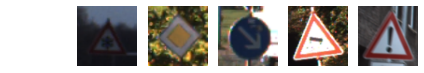

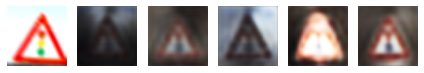

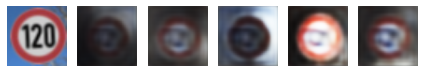

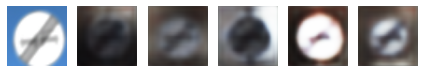

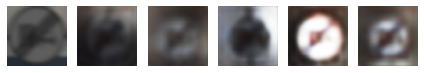

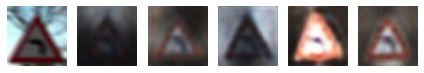

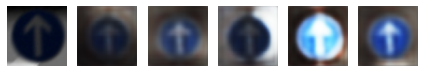

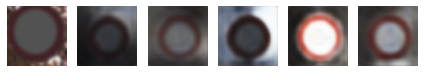

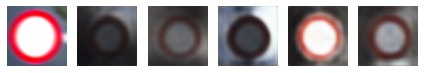

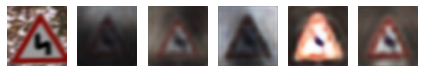

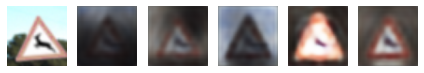

In [13]:
plot_target_cross_domain_swapping(model, source_loader, target_loader)
#plot_tsne(model, source_train_loader, target_train_loader, 128, 75)